### Init (import libraries and define common functions)

In [1]:
import sys
import pandas as pd
import json
from urllib.request import urlopen
from IPython.display import display, Markdown

def exists(name):
    return name in locals() or name in globals()

if not exists('currencies'):
    currencies = {}
else:
    print('Keeping the existing cache of currency conversion rates')

"""One euro is equivalent to X in the other currency"""
def euro_equivalent(c):
    c = c.lower()
    if c in currencies:
        return currencies[c]
    else:
        try:
            url = "https://cdn.jsdelivr.net/gh/fawazahmed0/currency-api@1/latest/currencies/eur/%s.json" % c
            res = urlopen(url)
            data = json.loads(res.read())
            conversion = data[c]
            currencies[c] = conversion
            print("New currency: %s (%f)" % (c, conversion))
            return conversion
        except:
            return sys.float_info.max
    
"""Multiply the salary X times to get the yearly compensation"""
def yearly_multiplier(freq):
    return 48 if freq == 'Weekly' else 12 if freq == 'Monthly' else 1

"""Remove the outliers from a dataframe based on the values of a single column.
Keep only the rows that, for the specified column, have values in between the [qlow, qhigh] quantiles.
"""
def remove_outliers(df, column, qlow, qhigh):
    low = df[column].quantile(qlow)
    high = df[column].quantile(qhigh)
    print('Keeping only %s in [%f, %f]' % (column, low, high))
    return df[(df[column] < high) & (df[column] > low)]

"""Print markdown in output"""
def print_md(string):
    display(Markdown(string))


### Clean the cache of currency conversion rates

In [78]:
currencies = {}

False

### Read the dataset (it takes a while the first time, to download all the currency rates)

In [2]:
df = pd.read_csv (r'./resources/developer_survey_2021/survey_results_public.csv', 
                  usecols=['Country', 'Currency', 'CompTotal', 'CompFreq', 'YearsCodePro', 'OrgSize'])
initsize = df.size
print("Size after import: %f" % initsize)

# clean it up
df = df.dropna()
print("Size after NA filtering: %f (-%s wrt import)" % (df.size, ((initsize - df.size) / initsize)))

df['YearsCodePro'] = df['YearsCodePro'].map(lambda v: 0 if v == 'Less than 1 year' else 55 if v == 'More than 50 years' else int(v))

# Keep only compensations that are reported as yearly total, as they seem more reliable.
# Montly compensations appear to be significantly lower, possibly because they are reported 
# after taxes instead than before
df = df[df.CompFreq == 'Yearly']
print("Size after compensation filtering: %f (-%s wrt import)" % (df.size, ((initsize - df.size) / initsize)))

# Remove unknown organization size
df = df[~df.OrgSize.str.startswith('I don')]
print("Size after org size filtering: %f (-%s wrt import)" % (df.size, ((initsize - df.size) / initsize)))

df['OrgSize'] = df['OrgSize'].map(lambda v: '1 ' if v.startswith("Just me") else v)
df['OrgSizeIdx'] = df.apply(lambda row: int(row['OrgSize'][:row['OrgSize'].find(' ')].replace(',','')), axis=1)

# calculate yearly compensation in EUR
df['Currency'] = df['Currency'].map(lambda s: str(s)[:3])
df['EuroYearlyComp'] = df.apply(lambda row: row['CompTotal'] * yearly_multiplier(row['CompFreq']) / euro_equivalent(row['Currency']), axis=1)


Size after import: 500634.000000
Size after NA filtering: 279234.000000 (-0.44223924064286485 wrt import)
Size after compensation filtering: 149766.000000 (-0.7008473255911504 wrt import)
Size after org size filtering: 147588.000000 (-0.7051978091779624 wrt import)
New currency: eur (1.000000)
New currency: cad (1.488456)
New currency: chf (1.085640)
New currency: gbp (0.857086)
New currency: usd (1.188350)
New currency: sek (10.155045)
New currency: rub (86.551098)
New currency: dkk (7.438982)
New currency: aud (1.593456)
New currency: inr (86.743195)
New currency: ils (3.803433)
New currency: hkd (9.235441)
New currency: egp (18.662003)
New currency: jpy (130.379230)
New currency: ars (116.298898)
New currency: try (9.890400)
New currency: nok (10.305669)
New currency: pln (4.508570)
New currency: cny (7.669017)
New currency: brl (6.168994)
New currency: irr (50136.487943)
New currency: twd (32.824961)
New currency: dop (67.527515)
New currency: gtq (9.197142)
New currency: idr (1693

In [23]:
df.query("Country == 'Afghanistan'").describe()

,YearsCodePro,CompTotal,EuroYearlyComp
count,4.000000,4.000000,4.000000
mean,5.500000,432858.250000,48072.736145
std,5.567764,413986.901772,48877.129081
min,0.000000,97333.000000,11509.626619
25%,2.250000,139908.250000,16544.149655
50%,4.500000,317050.000000,31265.662223
75%,7.750000,610000.000000,62794.248713
max,13.000000,1000000.000000,118249.993513


In [52]:
%matplotlib widget

import matplotlib
import matplotlib.pyplot as plt

groups = df.groupby('CompFreq')
for name, group in groups:
    plt.plot(group['EuroYearlyComp'], group['YearsCodePro'], marker=".", linestyle="", label=name, alpha=.1)
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Australia

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  37654   |
|       0.1  |  43427.6 |
|       0.25 |  56481   |
|       0.5  |  75308   |
|       0.75 |  94135   |
|       0.9  | 125513   |
|       0.95 | 150616   |

Keeping only EuroYearlyComp in [37654.004880, 150616.019520]


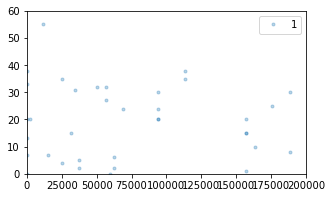

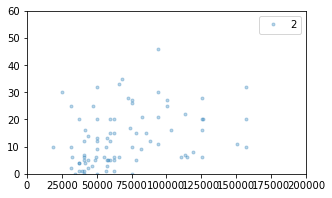

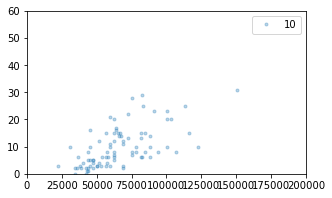

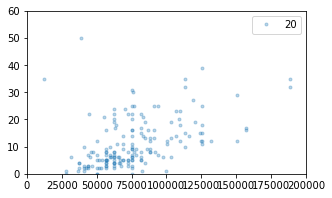

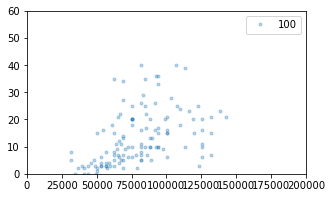

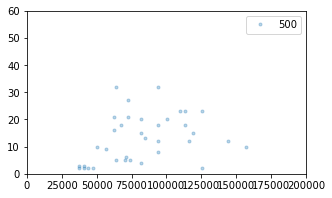

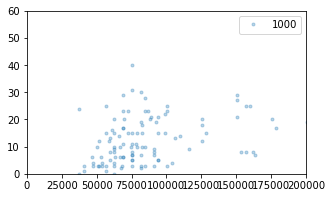

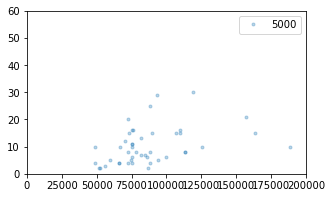

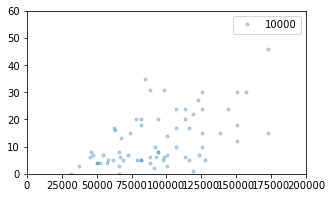

## Austria

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  32400   |
|       0.1  |  38740   |
|       0.25 |  49217.5 |
|       0.5  |  60000   |
|       0.75 |  70000   |
|       0.9  |  90000   |
|       0.95 | 100000   |

Keeping only EuroYearlyComp in [32400.000000, 100000.000000]


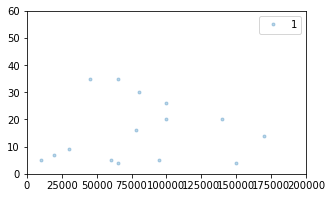

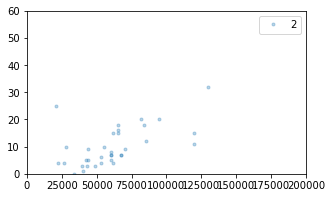

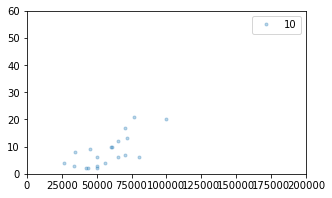

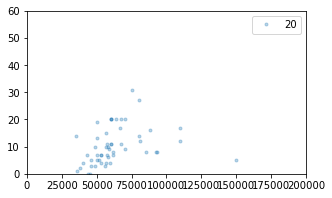

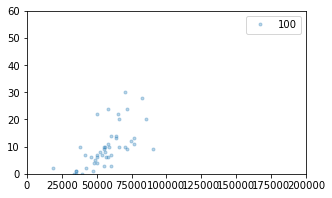

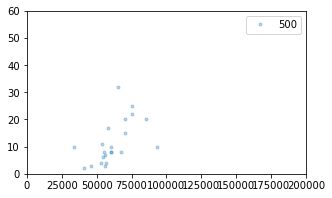

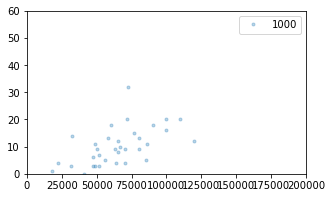

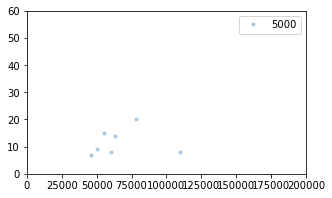

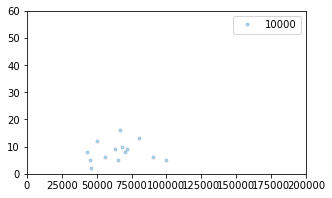

## Brazil

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  7780.85 |
|       0.1  | 10098    |
|       0.25 | 16210.1  |
|       0.5  | 27881.4  |
|       0.75 | 49278.7  |
|       0.9  | 72705.9  |
|       0.95 | 92565.3  |

Keeping only EuroYearlyComp in [7780.847250, 92565.321664]


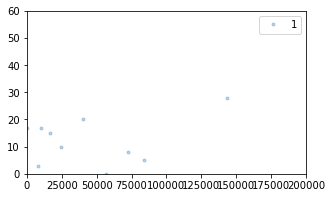

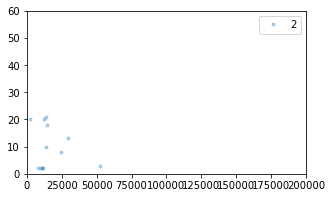

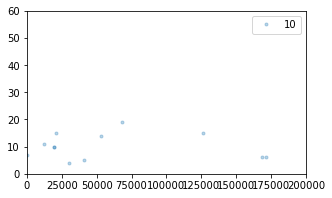

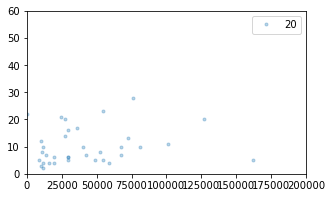

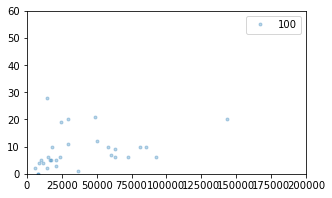

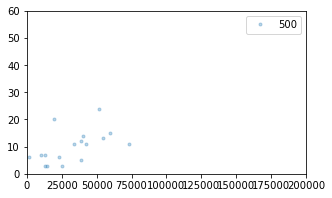

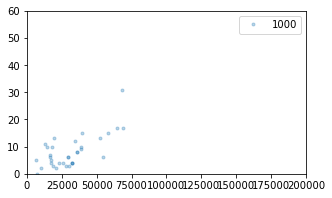

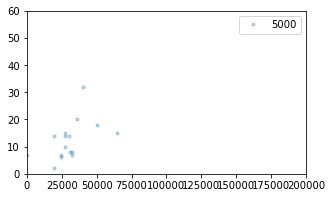

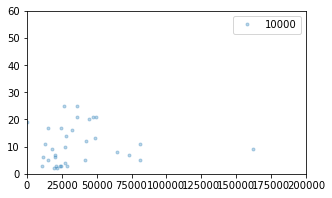

## Canada

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  33591.9 |
|       0.1  |  40310.2 |
|       0.25 |  51665.8 |
|       0.5  |  67183.7 |
|       0.75 |  87338.8 |
|       0.9  | 117571   |
|       0.95 | 141086   |

Keeping only EuroYearlyComp in [33591.856259, 141085.796288]


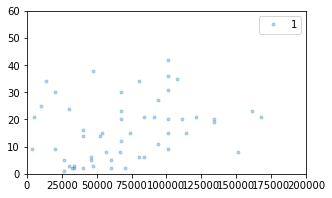

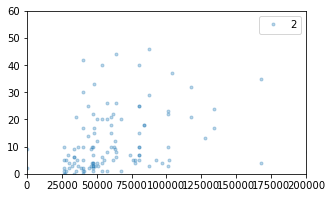

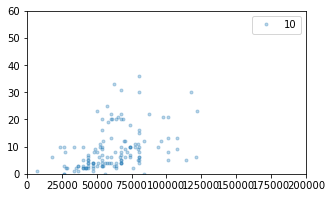

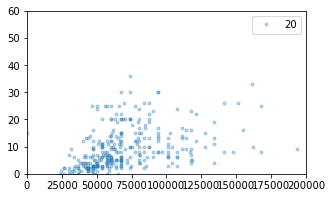

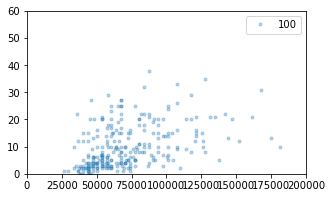

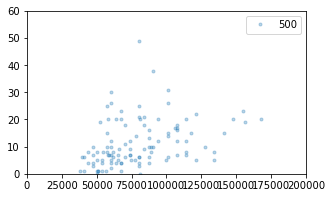

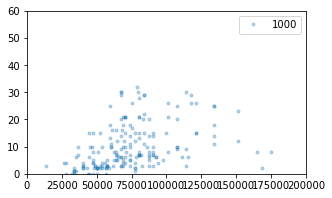

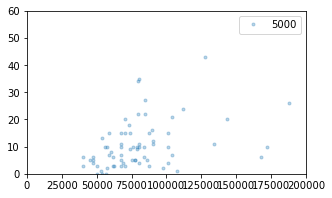

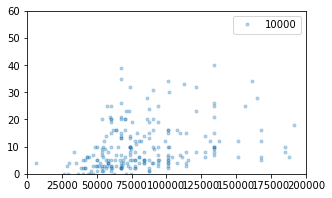

## France

### Yearly Compensation (EUR)

|   Quantile |   Comp. |
|-----------:|--------:|
|       0.05 |   30000 |
|       0.1  |   33000 |
|       0.25 |   39000 |
|       0.5  |   48000 |
|       0.75 |   62000 |
|       0.9  |   84000 |
|       0.95 |  110000 |

Keeping only EuroYearlyComp in [30000.000000, 110000.000000]


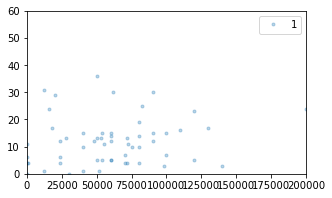

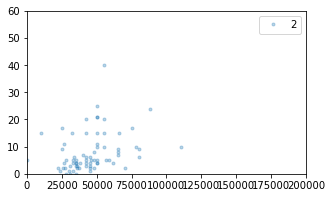

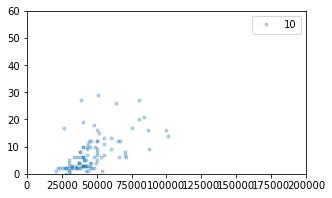

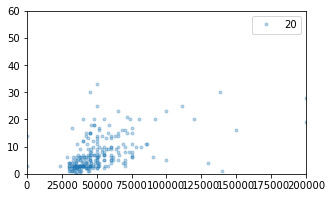

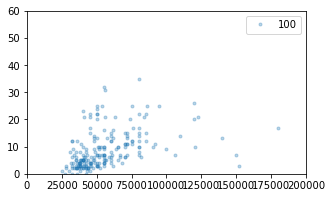

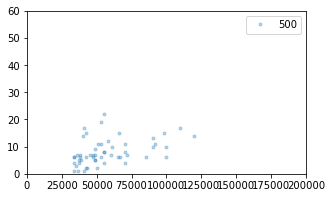

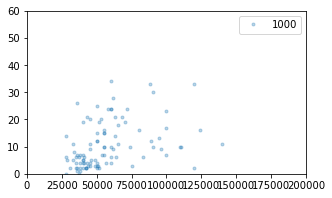

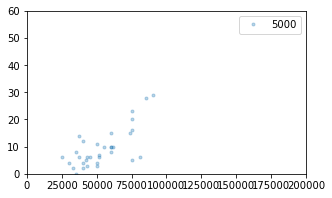

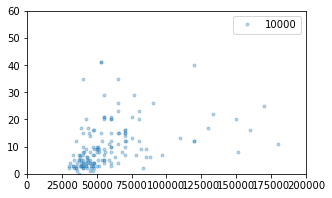

## Germany

### Yearly Compensation (EUR)

|   Quantile |   Comp. |
|-----------:|--------:|
|       0.05 |   39000 |
|       0.1  |   44000 |
|       0.25 |   54000 |
|       0.5  |   65000 |
|       0.75 |   80000 |
|       0.9  |  100000 |
|       0.95 |  120000 |

Keeping only EuroYearlyComp in [39000.000000, 120000.000000]


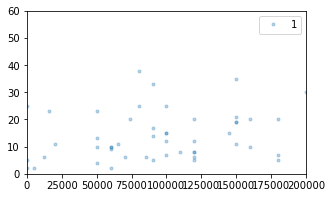

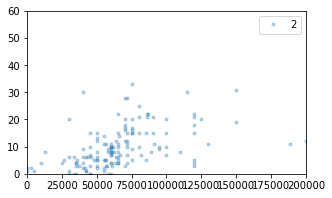

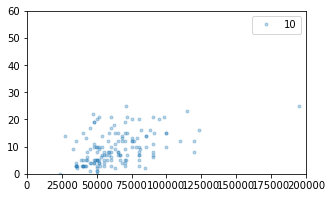

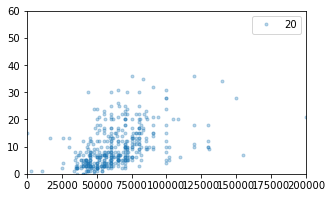

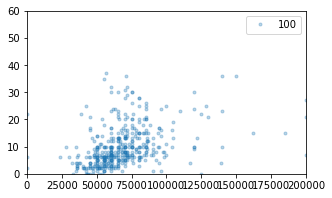

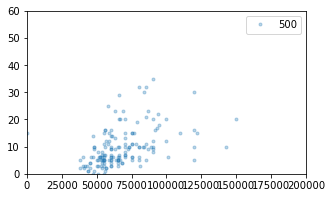

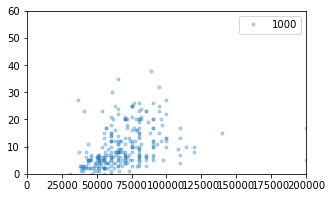

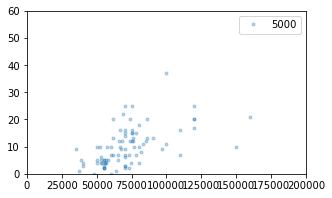

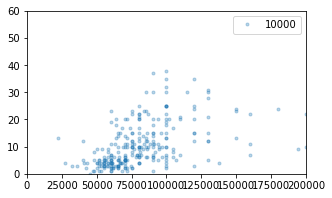

## India

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  3458.48 |
|       0.1  |  4613.62 |
|       0.25 |  8274.42 |
|       0.5  | 14986.8  |
|       0.75 | 24209.4  |
|       0.9  | 40349    |
|       0.95 | 53548.9  |

Keeping only EuroYearlyComp in [3458.484553, 53548.869165]


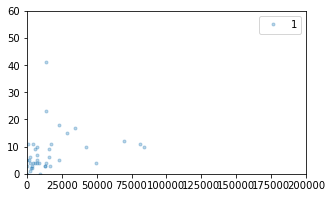

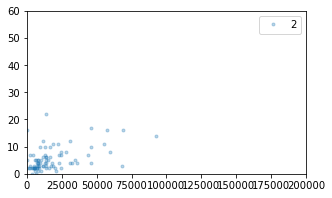

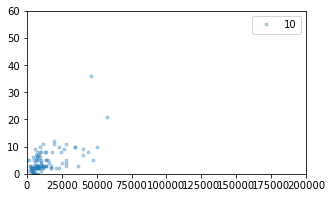

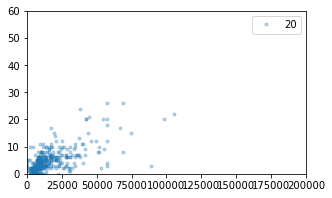

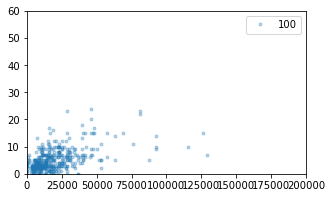

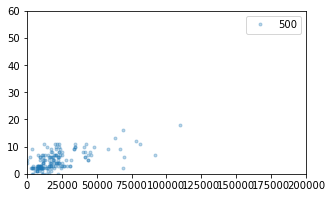

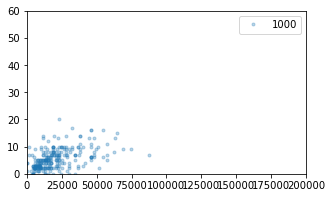

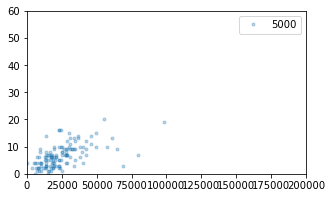

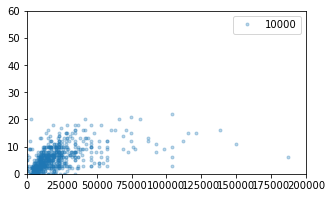

## Ireland

### Yearly Compensation (EUR)

|   Quantile |   Comp. |
|-----------:|--------:|
|       0.05 |   32900 |
|       0.1  |   40000 |
|       0.25 |   51000 |
|       0.5  |   74000 |
|       0.75 |  100000 |
|       0.9  |  130000 |
|       0.95 |  160500 |

Keeping only EuroYearlyComp in [32900.000000, 160500.000000]


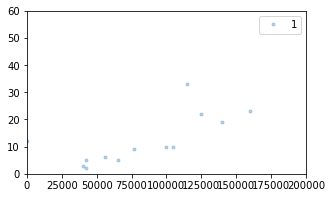

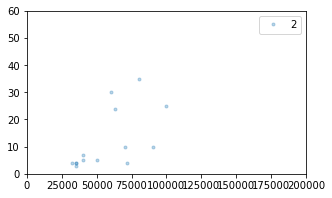

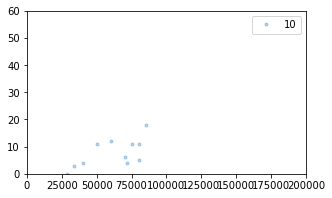

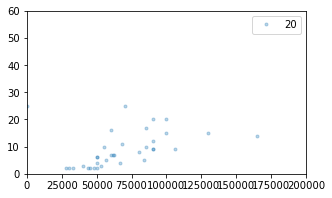

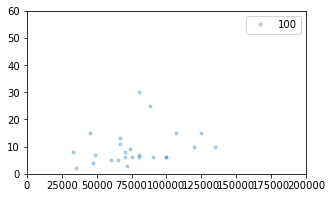

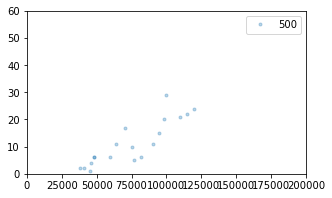

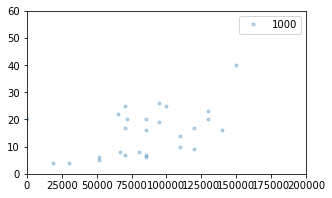

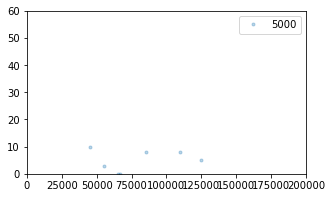

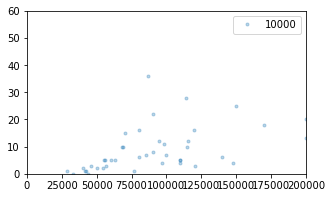

## Italy

### Yearly Compensation (EUR)

|   Quantile |   Comp. |
|-----------:|--------:|
|       0.05 |   22000 |
|       0.1  |   25000 |
|       0.25 |   30000 |
|       0.5  |   39000 |
|       0.75 |   50000 |
|       0.9  |   67928 |
|       0.95 |   87750 |

Keeping only EuroYearlyComp in [22000.000000, 87750.000000]


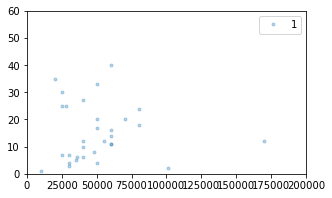

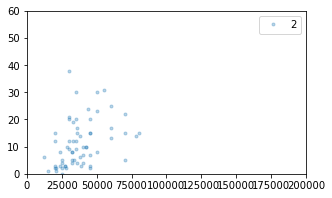

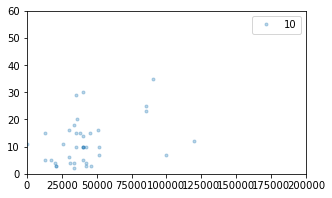

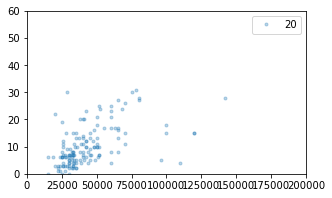

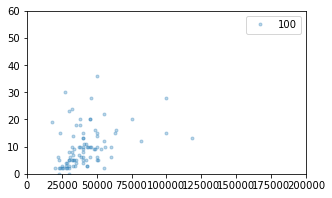

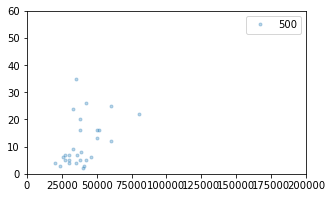

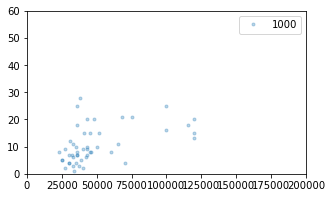

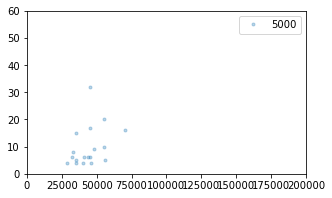

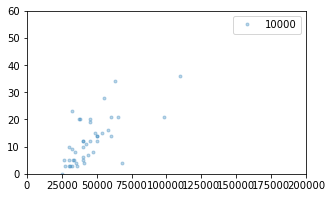

## Japan

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  28532.2 |
|       0.1  |  30679.7 |
|       0.25 |  42184.6 |
|       0.5  |  61359.5 |
|       0.75 |  83602.3 |
|       0.9  | 113172   |
|       0.95 | 138826   |

Keeping only EuroYearlyComp in [28532.151939, 138825.793035]


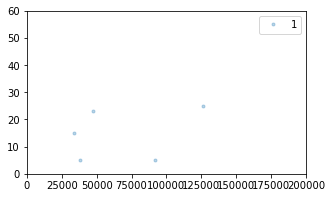

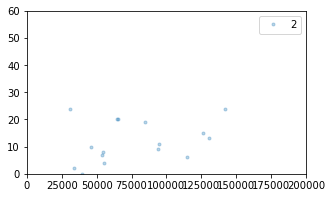

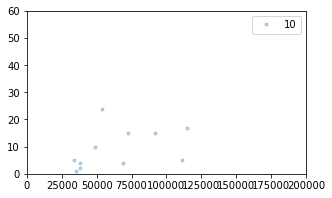

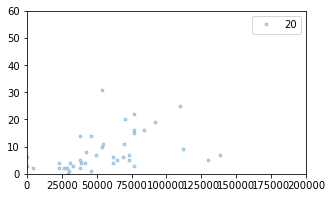

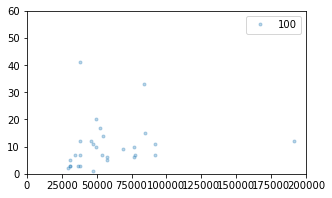

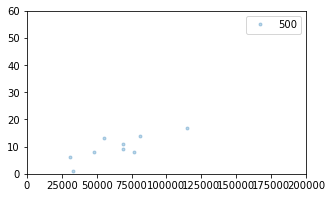

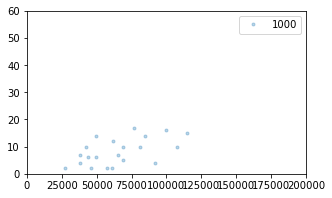

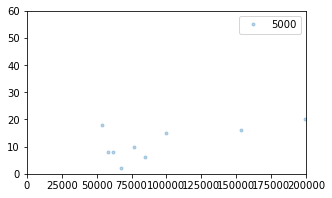

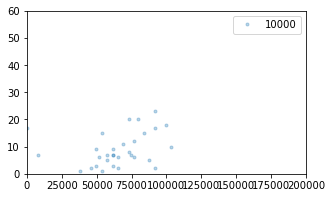

## Netherlands

### Yearly Compensation (EUR)

|   Quantile |   Comp. |
|-----------:|--------:|
|       0.05 |   37825 |
|       0.1  |   43000 |
|       0.25 |   52770 |
|       0.5  |   70000 |
|       0.75 |   85000 |
|       0.9  |  120000 |
|       0.95 |  150000 |

Keeping only EuroYearlyComp in [37825.000000, 150000.000000]


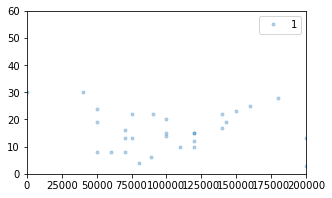

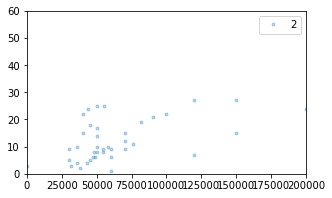

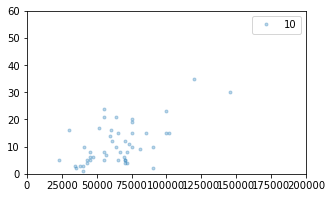

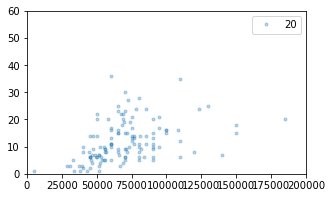

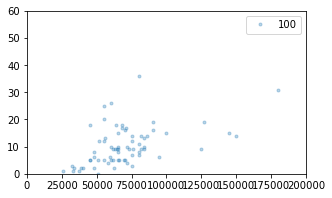

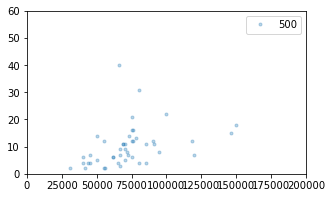

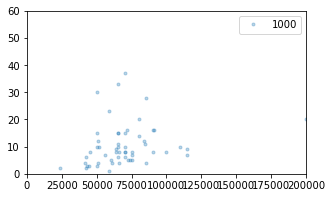

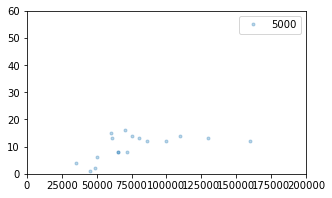

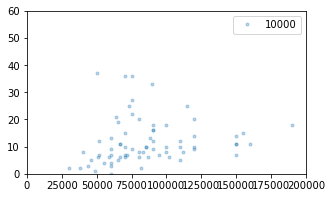

## New Zealand

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  33092.8 |
|       0.1  |  39109.6 |
|       0.25 |  48135   |
|       0.5  |  65583.9 |
|       0.75 |  80626   |
|       0.9  |  96269.9 |
|       0.95 | 126626   |

Keeping only EuroYearlyComp in [33092.778915, 126625.985282]


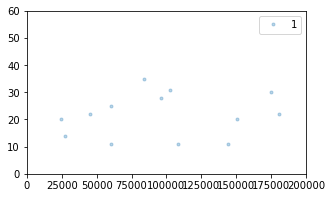

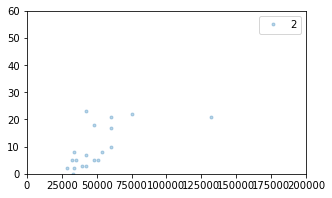

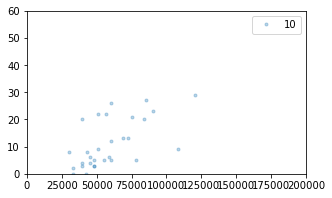

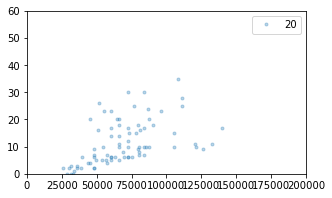

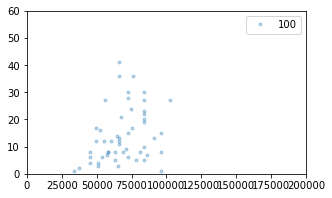

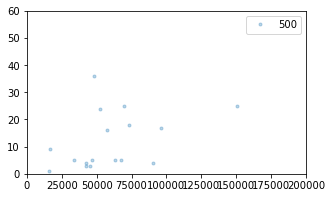

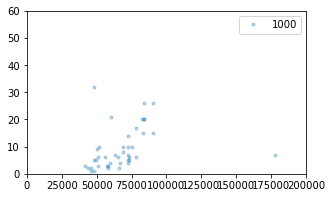

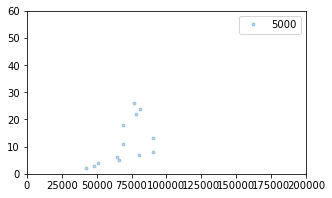

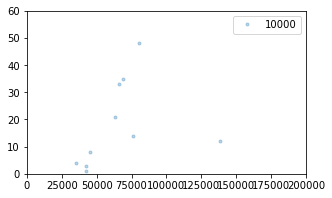

## Norway

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  46576.3 |
|       0.1  |  51428   |
|       0.25 |  59748.7 |
|       0.5  |  72629.9 |
|       0.75 |  87330.6 |
|       0.9  | 106737   |
|       0.95 | 116441   |

Keeping only EuroYearlyComp in [46576.306691, 116440.766728]


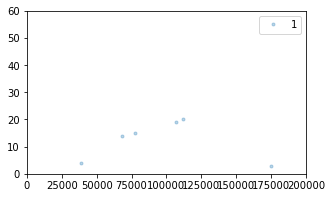

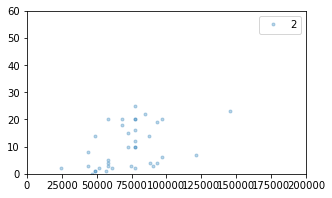

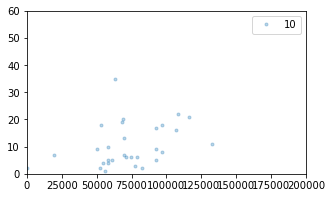

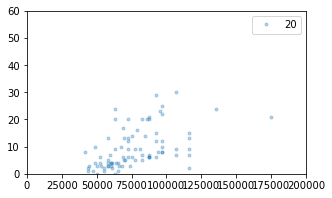

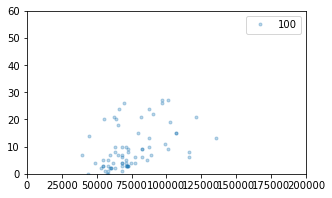

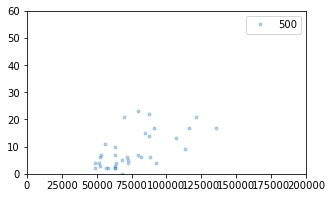

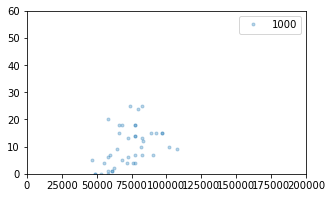

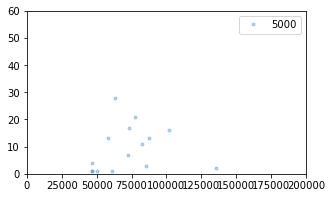

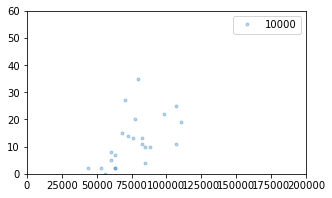

## Portugal

### Yearly Compensation (EUR)

|   Quantile |   Comp. |
|-----------:|--------:|
|       0.05 |   20000 |
|       0.1  |   23000 |
|       0.25 |   30000 |
|       0.5  |   42000 |
|       0.75 |   55000 |
|       0.9  |   75000 |
|       0.95 |   88000 |

Keeping only EuroYearlyComp in [20000.000000, 88000.000000]


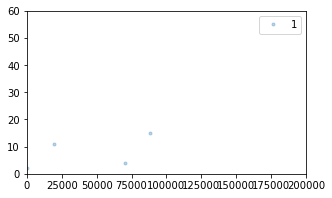

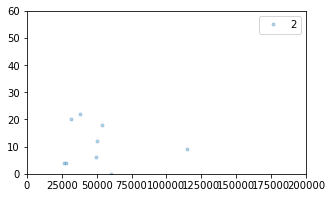

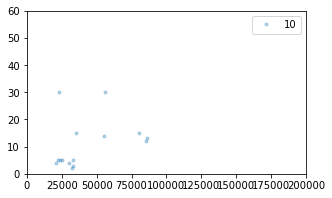

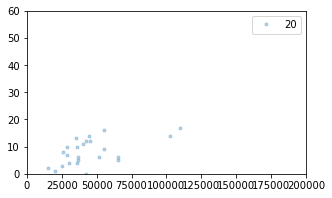

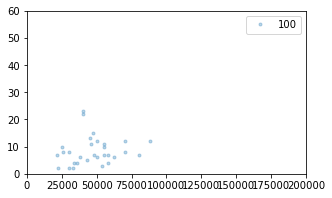

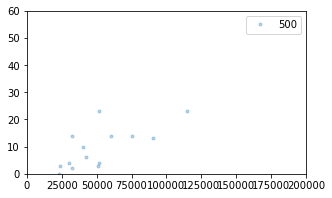

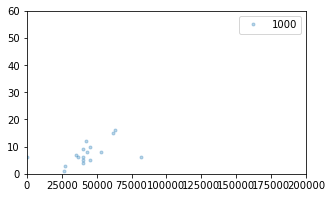

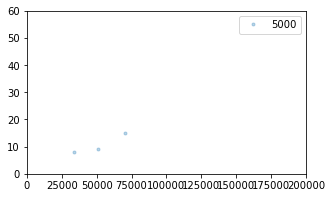

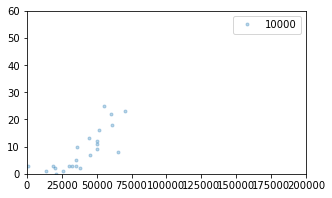

## Spain

### Yearly Compensation (EUR)

|   Quantile |   Comp. |
|-----------:|--------:|
|       0.05 |   18000 |
|       0.1  |   21500 |
|       0.25 |   30000 |
|       0.5  |   40000 |
|       0.75 |   52000 |
|       0.9  |   70000 |
|       0.95 |   86750 |

Keeping only EuroYearlyComp in [18000.000000, 86750.000000]


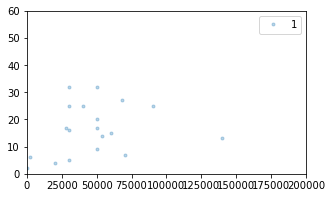

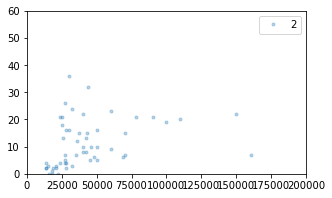

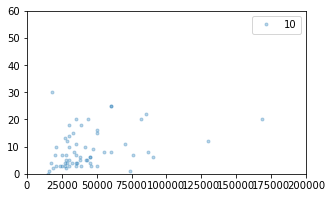

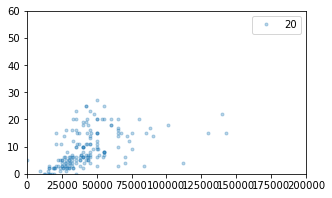

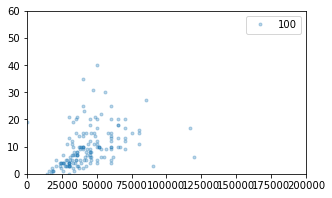

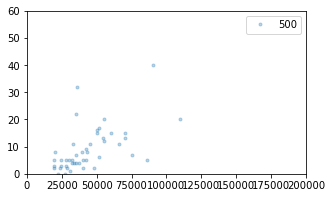

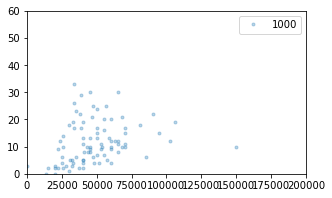

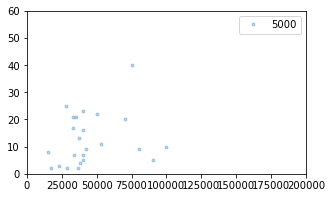

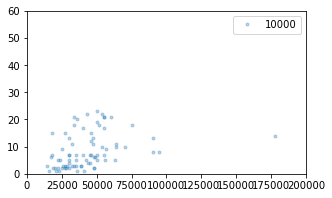

## Switzerland

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  61295.6 |
|       0.1  |  69083.7 |
|       0.25 |  82900.4 |
|       0.5  |  99019.9 |
|       0.75 | 119745   |
|       0.9  | 138167   |
|       0.95 | 165801   |

Keeping only EuroYearlyComp in [61295.641281, 165800.817951]


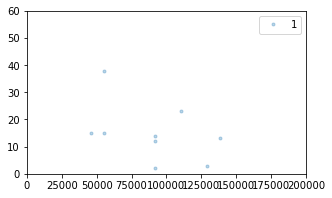

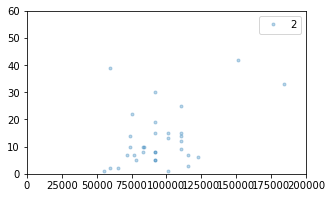

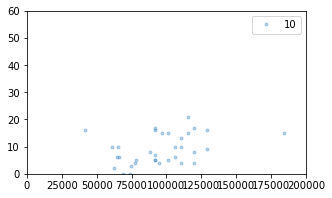

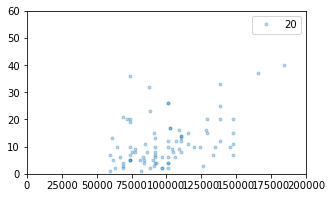

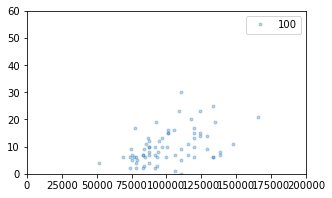

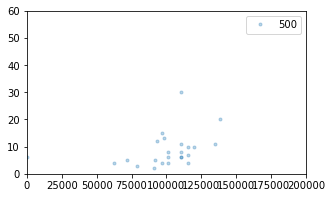

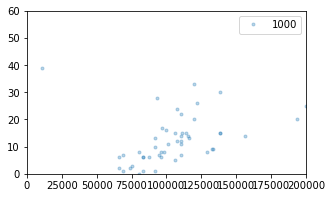

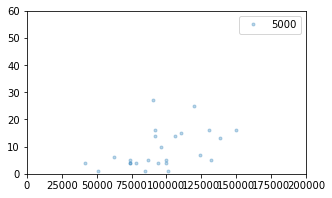

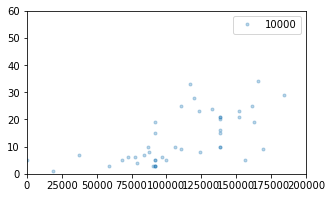

## United Kingdom of Great Britain and Northern Ireland

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  29168.6 |
|       0.1  |  35002.3 |
|       0.25 |  46669.8 |
|       0.5  |  64170.9 |
|       0.75 |  87505.8 |
|       0.9  | 122508   |
|       0.95 | 157044   |

Keeping only EuroYearlyComp in [29168.601517, 157043.750569]


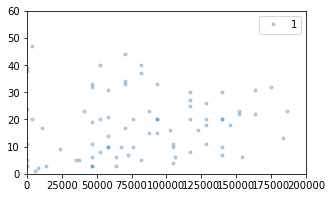

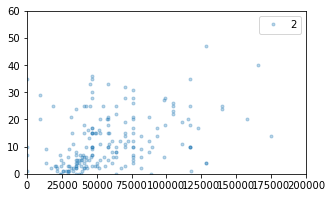

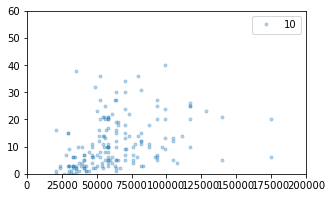

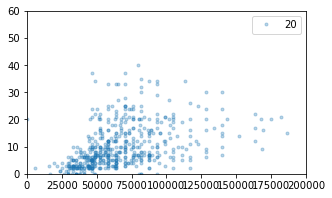

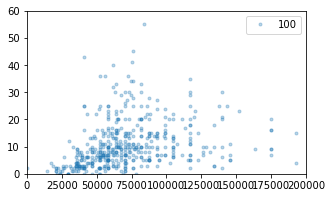

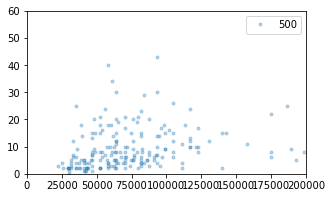

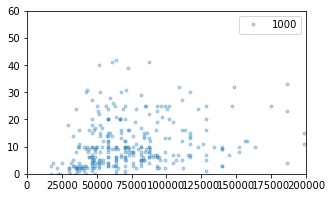

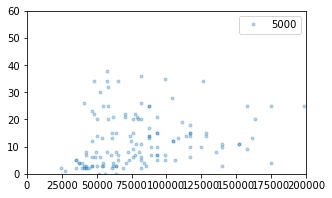

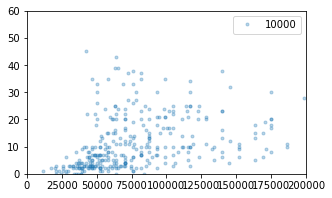

## United States of America

### Yearly Compensation (EUR)

|   Quantile |    Comp. |
|-----------:|---------:|
|       0.05 |  47534.4 |
|       0.1  |  58905.2 |
|       0.25 |  78259.8 |
|       0.5  | 105188   |
|       0.75 | 138848   |
|       0.9  | 189338   |
|       0.95 | 244877   |

Keeping only EuroYearlyComp in [47534.396432, 244877.350949]


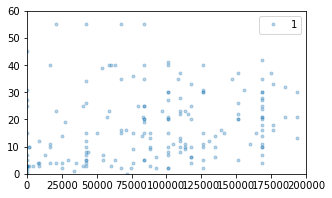

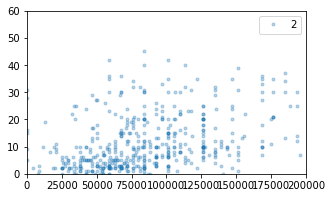

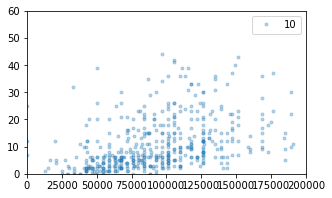

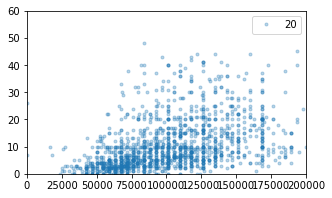

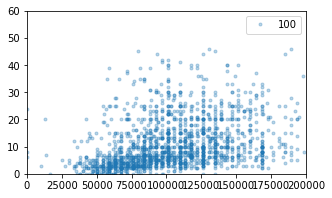

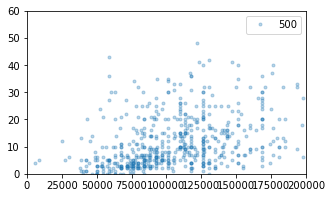

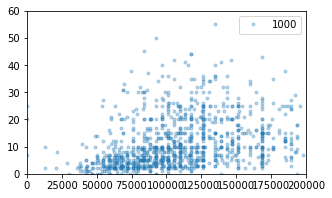

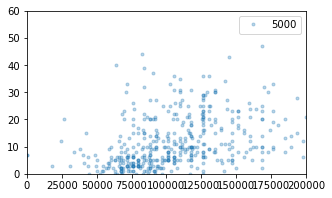

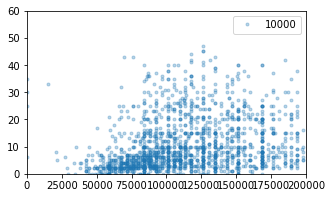

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def country_report(name, df):
    print_md("## %s" % name)
    print_md("### Yearly Compensation (EUR)")
    quantiles = pd.DataFrame([[q, df['EuroYearlyComp'].quantile(q)] for q in [.05, .1, .25, .5, .75, .9, .95]], columns = ['Quantile', 'Comp.'])
    print_md(quantiles.to_markdown(index=False))
    points = remove_outliers(group,'EuroYearlyComp', .05, .95)
    
    bysize = df.groupby('OrgSizeIdx')
    for orgsize, data in bysize:
        fig = plt.figure()
        plt.plot(data['EuroYearlyComp'], data['YearsCodePro'], marker=".", linestyle="", label=orgsize, alpha=.3)  
        x1,x2,y1,y2 = plt.axis()  
        plt.axis((0, 200000, 0, 60))
        plt.legend()
    plt.show()
#     plt.plot(points['EuroYearlyComp'], points['YearsCodePro'], marker=".", linestyle="", label=name, alpha=.3)
#     x1,x2,y1,y2 = plt.axis()  
#     plt.axis((0, 200000, 0, 60))
#     plt.show()

plt.rcParams["figure.figsize"] = (5,3)
groups = df.groupby('Country')
for name, group in groups:
    if group.size > 1000: # ignore countries with few data points
        country_report(name, group)


